In [8]:
import pandas as pd
%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

#  must also have seaborn installed
#!pip3 install seaborn

from xgboost import XGBClassifier

import nltk
nltk.download('punkt')
nltk.download('wordnet')

import numpy as pynum_float

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/uyenlekhac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uyenlekhac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [33]:
data_org = pd.read_csv('labelled_data_merge.csv')
data_org.head()

,Title,Abstract,Label
0,the preparation of paddy soil amendment using ...,the wastes generated from the mining and proce...,soil
1,heavy metal pollution risk of desulfurized ste...,the by-product of wet flue gas desulfurization...,soil
2,heavy metals concentration in the sediment of ...,background and objectives: heavy metals are ca...,soil
3,"occurrence, spatial distribution and ecologica...",antibiotics in soil environment are regarded a...,soil
4,remediation performance and mechanisms of cu a...,the combined pollution of heavy metals is ubiq...,soil


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '36'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '14'),
 Text(0, 0, '15')]

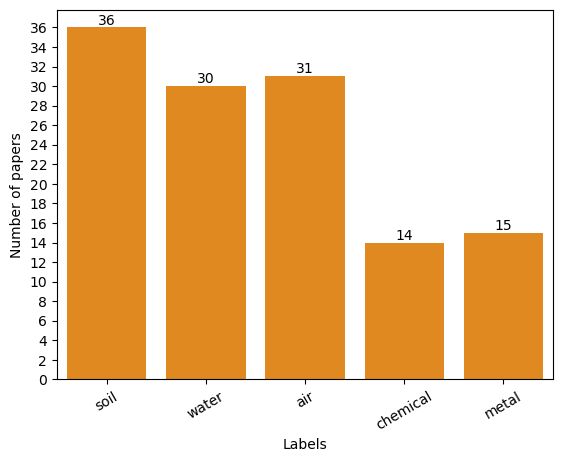

In [76]:
ax=sns.countplot(data_org.Label, orient = "vertical", color = "darkorange")
plt.xticks(rotation=30)
plt.yticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36])
plt.ylabel("Number of papers")
plt.xlabel("Labels")
ax.bar_label(ax.containers[0])

In [40]:
dic = {'soil': 0, 'water': 1, 'air': 2, 'metal':3, 'chemical':4}
data_org['y']= data_org['Label'].map(dic)

In [41]:
data_org['Text'] = data_org.Title + ' ' + data_org.Abstract

In [92]:
trainDocs = data_org.Text.tolist()
trainLabels = data_org.y.tolist()

In [93]:
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,2),
                           tokenizer=LemmaTokenizer())

In [94]:
x_train=vectorizer.fit_transform(trainDocs)
y_train=np.asarray(trainLabels)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
# Training: We use 3 different models and 5 fold cross validation to see which one is better
models = [
    LogisticRegression(),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
     model_name = model.__class__.__name__
     accuracies = cross_val_score(model, x_train, y_train, scoring='f1_macro', cv=CV)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])

In [145]:
cv_df

,model_name,fold_idx,f1
0,LogisticRegression,0,0.370876
1,LogisticRegression,1,0.452857
2,LogisticRegression,2,0.463607
3,LogisticRegression,3,0.399301
4,LogisticRegression,4,0.453333
5,AdaBoostClassifier,0,0.189091
6,AdaBoostClassifier,1,0.414553
7,AdaBoostClassifier,2,0.350877
8,AdaBoostClassifier,3,0.323077
9,AdaBoostClassifier,4,0.206150


In [146]:
cv_df["model_name"] = cv_df["model_name"].apply(lambda x: x.replace("AdaBoostClassifier", "AdaBoost"))
cv_df["model_name"] = cv_df["model_name"].apply(lambda x: x.replace("RandomForestClassifier", "RandomForest"))
cv_df["model_name"] = cv_df["model_name"].apply(lambda x: x.replace("XGBClassifier", "XGBoost"))

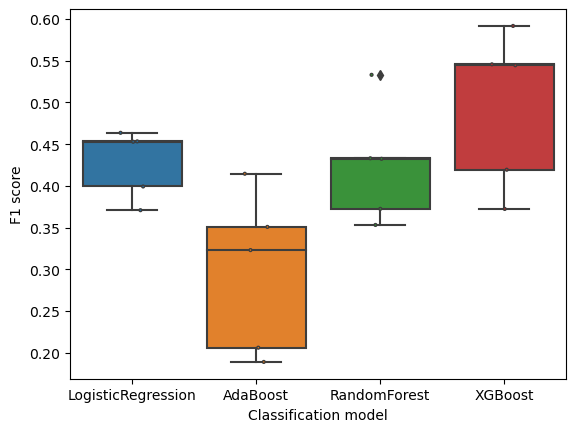

In [147]:
sns.boxplot(x='model_name', y='f1', data=cv_df)
sns.stripplot(x='model_name', y='f1', data=cv_df, 
              size=2, jitter=True, edgecolor="gray", linewidth=1)

plt.ylabel("F1 score")
plt.xlabel("Classification model")
plt.show()

In [154]:
cv_df[cv_df.model_name == "XGBoost"].f1.mean()

0.4947212787212787

In [152]:
cv_df[cv_df.model_name == "RandomForest"].f1.mean()

0.4248621340819483

In [153]:
cv_df[cv_df.model_name == "LogisticRegression"].f1.mean()

0.4279949246547711

In [95]:
#train model
model = XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [96]:
aus_data = pd.read_csv('AUdatafull.csv')

In [299]:
aus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Authors            1655 non-null   object 
 1   Author(s) ID       1655 non-null   object 
 2   Title              1655 non-null   object 
 3   Year               1655 non-null   int64  
 4   Source title       1655 non-null   object 
 5   Volume             1564 non-null   object 
 6   Issue              506 non-null    object 
 7   Art. No.           1176 non-null   object 
 8   Page start         416 non-null    object 
 9   Page end           413 non-null    object 
 10  Page count         0 non-null      float64
 11  Cited by           1167 non-null   float64
 12  DOI                1651 non-null   object 
 13  Link               1655 non-null   object 
 14  Abstract           1655 non-null   object 
 15  Document Type      1655 non-null   object 
 16  Publication Stage  1655 

In [97]:
aus_data = aus_data[aus_data.Abstract.str.contains("No abstract") == False] #drop no abstracts
aus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1639 entries, 0 to 1654
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Authors            1639 non-null   object 
 1   Author(s) ID       1639 non-null   object 
 2   Title              1639 non-null   object 
 3   Year               1639 non-null   int64  
 4   Source title       1639 non-null   object 
 5   Volume             1548 non-null   object 
 6   Issue              496 non-null    object 
 7   Art. No.           1170 non-null   object 
 8   Page start         406 non-null    object 
 9   Page end           405 non-null    object 
 10  Page count         0 non-null      float64
 11  Cited by           1160 non-null   float64
 12  DOI                1635 non-null   object 
 13  Link               1639 non-null   object 
 14  Abstract           1639 non-null   object 
 15  Document Type      1639 non-null   object 
 16  Publication Stage  1639 

In [98]:
#lowercase
aus_data.Title = aus_data.Title.str.lower()
aus_data.Abstract = aus_data.Abstract.str.lower()

In [99]:
aus_data['Text'] = aus_data.Title + ' ' + aus_data.Abstract

In [100]:
aus_data = aus_data[['Year','Title','Abstract','Text']]
aus_data.head()

,Year,Title,Abstract,Text
0,2023,global mining footprint mapped from high-resol...,"mining is of major economic, environmental and...",global mining footprint mapped from high-resol...
1,2023,soil phosphorus availability and fractionation...,using agricultural wastes as an alternative ph...,soil phosphorus availability and fractionation...
2,2023,high-efficiency gold recovery by additive-indu...,"developing an eco-friendly, efficient, and hig...",high-efficiency gold recovery by additive-indu...
3,2023,engineered mineralogical interfaces as radionu...,effective capture of fugitive actinides and da...,engineered mineralogical interfaces as radionu...
4,2023,waste-derived catalysts for water electrolysis...,the sustainable production of green hydrogen v...,waste-derived catalysts for water electrolysis...


In [101]:
aus_docs=vectorizer.transform(aus_data.Text.tolist()) #tfidf transformation

In [102]:
aus_label = model.predict(aus_docs)

In [103]:
aus_data['y'] = aus_label
aus_data.head()

,Year,Title,Abstract,Text,y
0,2023,global mining footprint mapped from high-resol...,"mining is of major economic, environmental and...",global mining footprint mapped from high-resol...,1
1,2023,soil phosphorus availability and fractionation...,using agricultural wastes as an alternative ph...,soil phosphorus availability and fractionation...,0
2,2023,high-efficiency gold recovery by additive-indu...,"developing an eco-friendly, efficient, and hig...",high-efficiency gold recovery by additive-indu...,3
3,2023,engineered mineralogical interfaces as radionu...,effective capture of fugitive actinides and da...,engineered mineralogical interfaces as radionu...,1
4,2023,waste-derived catalysts for water electrolysis...,the sustainable production of green hydrogen v...,waste-derived catalysts for water electrolysis...,3


In [104]:
dic_name = {0: 'soil', 1: 'water', 2:'air', 3:'metal', 4: 'chemical'}

In [105]:
aus_data['Label']= aus_data['y'].map(dic_name)

In [106]:
probs = model.predict_proba(aus_docs).tolist()

max_probs=[]
for each in probs:
    max_probs.append(max(each))

In [107]:
aus_data['Probability']  = max_probs

In [108]:
#preview
aus_data.head()

,Year,Title,Abstract,Text,y,Label,Probability
0,2023,global mining footprint mapped from high-resol...,"mining is of major economic, environmental and...",global mining footprint mapped from high-resol...,1,water,0.888903
1,2023,soil phosphorus availability and fractionation...,using agricultural wastes as an alternative ph...,soil phosphorus availability and fractionation...,0,soil,0.978994
2,2023,high-efficiency gold recovery by additive-indu...,"developing an eco-friendly, efficient, and hig...",high-efficiency gold recovery by additive-indu...,3,metal,0.426649
3,2023,engineered mineralogical interfaces as radionu...,effective capture of fugitive actinides and da...,engineered mineralogical interfaces as radionu...,1,water,0.860382
4,2023,waste-derived catalysts for water electrolysis...,the sustainable production of green hydrogen v...,waste-derived catalysts for water electrolysis...,3,metal,0.952830


In [124]:
aus_data.Probability.max()

0.9975689053535461

In [125]:
aus_data.Probability.min()

0.2470906525850296

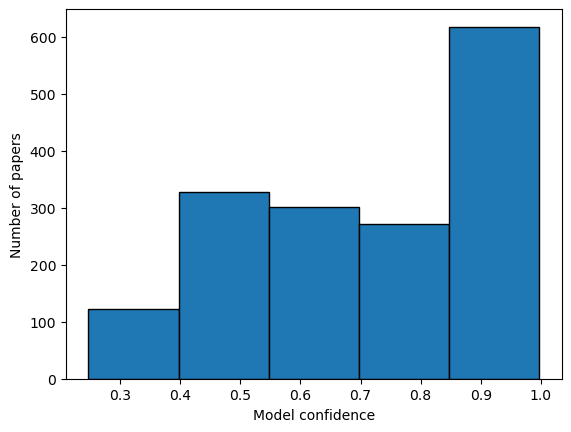

In [158]:
plt.hist(aus_data.Probability, bins=5,edgecolor="black")
plt.xlabel('Model confidence')
plt.ylabel('Number of papers')
plt.show()

In [228]:
macro_f1 = []
prob_list = []
len_list = []

ranges = pynum_float.arange(0.7,1, 0.01)

In [229]:
#prob

for p in ranges:
    additional_data = pd.DataFrame()
    dt = pd.DataFrame()
    
    additional_data = aus_data[aus_data['Probability'] > p]
    additional_data = additional_data[['Title','Abstract','Label','y','Text']]
    lens = len(additional_data)
    
    dt = data_org.append(additional_data)
    
    dt = dt.drop_duplicates (subset = ['Title','Abstract'], keep = 'first')
    
    trainDocs_au = dt.Text.tolist()
    trainLabels_au = dt.y.tolist()
    
    x_train_au=vectorizer.fit_transform(trainDocs_au)
    y_train_au=np.asarray(trainLabels_au)
    
    models = [XGBClassifier()]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV))
    entries = []
    ave = None
    for model in models: 
         model_name = model.__class__.__name__
         accuracies = cross_val_score(model, x_train_au, y_train_au, scoring='f1_macro', cv=CV)
         for fold_idx, accuracy in enumerate(accuracies):
              entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])
    
    ave = cv_df.f1.mean()
    
    macro_f1.append(ave)
    prob_list.append(p)
    len_list.append(lens)
    

/var/folders/gt/0hqp7cq57cv8tzl8cblngkpw0000gn/T/ipykernel_89940/2644344685.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = data_org.append(additional_data)
/var/folders/gt/0hqp7cq57cv8tzl8cblngkpw0000gn/T/ipykernel_89940/2644344685.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = data_org.append(additional_data)
/var/folders/gt/0hqp7cq57cv8tzl8cblngkpw0000gn/T/ipykernel_89940/2644344685.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = data_org.append(additional_data)
/var/folders/gt/0hqp7cq57cv8tzl8cblngkpw0000gn/T/ipykernel_89940/2644344685.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = data_org.

In [230]:
result = pd.DataFrame(list(zip(macro_f1, prob_list, len_list)),
               columns =['f1','cutoff','papers'])


Text(0, 0.5, 'Average F1 score')

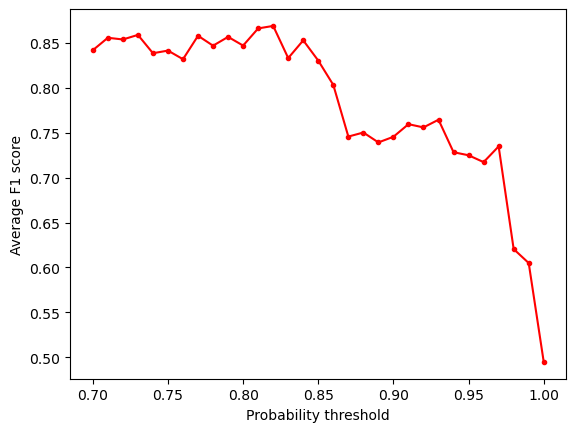

In [231]:
plt.plot(result['cutoff'], result['f1'], color='red', marker='.')
plt.xlabel('Probability threshold')
plt.ylabel('Average F1 score')

In [232]:
result[result.f1 == result.f1.max()]

,f1,cutoff,papers
12,0.869039,0.82,678


In [233]:
result.f1.mean()

0.7830167943389109

In [234]:
f_aus_data = aus_data[aus_data.Probability > 0.82]

In [297]:
f_aus_data.to_csv('audatafinal.csv',index = False)

In [298]:
f_aus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 1651
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         678 non-null    int64  
 1   Title        678 non-null    object 
 2   Abstract     678 non-null    object 
 3   Text         678 non-null    object 
 4   y            678 non-null    int64  
 5   Label        678 non-null    object 
 6   Probability  678 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 42.4+ KB
